# HW3 - PEFT

**Name**: Nikan Vasei  
  
**Student Code**: 400105303

In this notebook, we will fine-tune the GPT2 model on the [WikiText](https://huggingface.co/datasets/Salesforce/wikitext#wikitext-2-v1) dataset using different fine-tuning methodologies.

Parameter-Efficient Fine-Tuning (PEFT) is a technique that enables the adaptation of large pre-trained models to specific tasks while modifying only a small subset of their parameters, significantly reducing computational and memory costs. Instead of updating all model parameters, PEFT methods, such as LoRA (Low-Rank Adaptation), Adapter layers, and Prefix-Tuning, introduce lightweight trainable modules that are inserted into the model or modify activations in a structured way. This approach retains the general knowledge of the base model while efficiently adapting to new tasks, making it particularly useful for fine-tuning large-scale models like LLMs and vision-language models on resource-constrained hardware.

## Install required libraries

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you 

## Import required libraries

In [2]:
import gc
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from datasets import load_dataset
from peft import LoraConfig, PrefixTuningConfig, get_peft_model, PeftModel

2025-05-05 13:46:29.604029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746452789.787457      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746452789.841332      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup

In [3]:
gpt_2_medium_model_name = "openai-community/gpt2-medium"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(gpt_2_medium_model_name)
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
def tokenizing_preprocess(examples):
    inputs =  tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)
    inputs['labels'] = inputs['input_ids'].copy()
    return inputs


# Define training arguments
training_args = TrainingArguments(
    output_dir='./gpt2',
    eval_strategy='no',
    save_strategy="no",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    report_to="none"
)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Load dataset (5 pt)

In [4]:
# TODO: Load the wikitext-2-v1 version of wikitext
dataset = load_dataset("wikitext", "wikitext-2-v1")

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/685k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.07M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [5]:
# TODO Select 1000 data for train and 500 data for validation
train_data = dataset["train"].select(range(1000))
eval_data = dataset["validation"].select(range(500))

# Apply tokenization preprocess on datasets
train_dataset = train_data.map(tokenizing_preprocess, batched=True)
eval_dataset = eval_data.map(tokenizing_preprocess, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## Full Fine-Tuning (5 pt)

In [6]:
# Load the model
ff_model = AutoModelForCausalLM.from_pretrained(gpt_2_medium_model_name)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
# Initialize Trainer
trainer = Trainer(
    model=ff_model,
    args=training_args,
    train_dataset=train_dataset,
)

In [8]:
# Zero-Shot evaluation of model

# TODO: Evaluate model on eval_dataset
eval_output = trainer.evaluate(eval_dataset=eval_dataset)

print(f"eval_loss = {eval_output['eval_loss']:.4f}")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


eval_loss = 6.9568


In [9]:
# TODO: Get reserved memory from cuda
gpu_memory_before = torch.cuda.memory_reserved()
# TODO: Train the model using trainer
train_output = trainer.train()
# TODO: Get reserved memory from cuda
gpu_memory_after = torch.cuda.memory_reserved()

# Report the training time and gpu memory consumption
print(f"Training time: {train_output.metrics['train_runtime']:.4f} seconds")
print(f"GPU memory used: {gpu_memory_after - gpu_memory_before:.4f} bytes")

Step,Training Loss


Training time: 71.5980 seconds
GPU memory used: 5542772736.0000 bytes


In [10]:
# TODO: Evaluate model on eval_dataset
eval_output = trainer.evaluate(eval_dataset=eval_dataset)

print(f"eval_loss = {eval_output['eval_loss']:.4f}")

eval_loss = 1.0844


In [11]:
# Delete the model
del ff_model
del trainer

In [12]:
# Empty the GPU memory (Run this cell twice if the GPU RAM is not close to zero(~0.2))
gc.collect()
torch.cuda.empty_cache()

## Prefix Tuning (20 pt)

<font color=cyan>

Before actually explaining the `Prefix Tuning` method, it's better to explain another method called `Soft Prompt Tuning`. In this method, rather than designing a prompt manually, we learn an optimal prefix for each of the available tasks. In other terms we basically follow these steps:
- Freeze all pretrained parameters.
- Learnable prompt is added to the input.
- The soft prompt is processed by the model like real words would be.

Now that we know how the Soft Prompt Tuning works, we can move onto Prefix Tuning. In Prefix Tuning, it’s not just the prompts in the prefix that get tuned, it's also the hidden representations of later layers that get tuned. Or in other terms we follow these steps:
- Freeze all pretrained parameters.
- Prepend certain trainable prefix tokens to the input and hidden
activations.
- The prefix is processed by the model just like real words would be.

This way we can also apply the multi-task setting, because each element of a batch at inference could actually run a different tuned model.

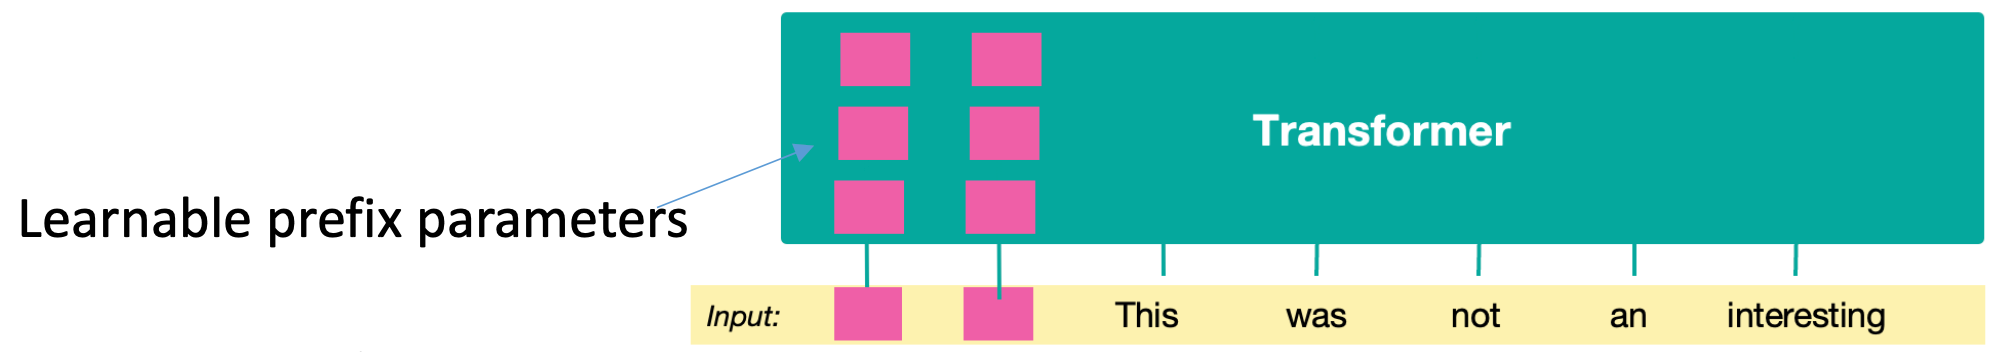

As you can see in this image some of the tokens, get some new learnable parameters (besides their later layers) and thus we can fine-tune our model using much lower amount of parameters.

In [13]:
from transformers import AutoModel
prefix_model = AutoModelForCausalLM.from_pretrained(gpt_2_medium_model_name)

In [14]:
# TODO: Define your LoRA configuration using PrefixTuningConfig class from peft library
#       Set task_type to CAUSAL_LM

prefixtuning_config = PrefixTuningConfig(
    task_type="CAUSAL_LM",
    inference_mode=False,
    num_virtual_tokens=20,
    prefix_projection=True,
    encoder_hidden_size=768
)

# TODO: Wrraped the GPT2LMHeadModel with above prefix config using get_peft_model function
prefix_model = get_peft_model(prefix_model, prefixtuning_config)

# TODO: Print number of trainable parameters
prefix_model.print_trainable_parameters()

trainable params: 38,605,568 || all params: 393,428,736 || trainable%: 9.8126


In [15]:
prefix_model

PeftModelForCausalLM(
  (base_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 1024)
      (wpe): Embedding(1024, 1024)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-23): 24 x GPT2Block(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=3072, nx=1024)
            (c_proj): Conv1D(nf=1024, nx=1024)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=4096, nx=1024)
            (c_proj): Conv1D(nf=1024, nx=4096)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_fea

In [16]:
# Initialize Trainer
trainer = Trainer(
    model=prefix_model,
    args=training_args,
    train_dataset=train_dataset,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [17]:
# TODO: Get reserved memory from cuda
gpu_memory_before = torch.cuda.memory_reserved()
# TODO: Train the model
train_output = trainer.train()
# TODO: Get reserved memory from cuda
gpu_memory_after = torch.cuda.memory_reserved()

# Report the training time and gpu memory consumption
print(f"Training time: {train_output.metrics['train_runtime']:.4f} seconds")
print(f"GPU memory used: {gpu_memory_after - gpu_memory_before:.4f} bytes")

Step,Training Loss


Training time: 46.8647 seconds
GPU memory used: 2168455168.0000 bytes


In [18]:
# TODO: Evaluate model on eval_dataset
eval_output = trainer.evaluate(eval_dataset=eval_dataset)

print(f"eval_loss = {eval_output['eval_loss']:.4f}")

eval_loss = 1.4616


In [19]:
# Delete the model
del prefix_model
del trainer

In [20]:
# Empty the GPU memory (Run this cell twice if the GPU RAM is not close or less than 1.5Gb)
gc.collect()
torch.cuda.empty_cache()

## Fine-Tuning by LoRA (Low-Rank Adaptation) (40 pt)

<font color=cyan>

`LoRA` is another PEFT method which is quite strong, because we can kinda tune it based on different tasks, the hardwares that we have, etc.
In this method we try to learn a low-dimensional space instead of the high-dimensional one that we previously had in our normal model. Suppose that in our original model, we take steps directly in the space of $\theta^{(D)}$. Now we introduce a randomly generated matrix $P$ and also a much lower-dimensional parameter $\theta^{(d)}$, and define our optimizer as below:
$$\theta^{(D)} = \theta^{(D)}_{0} + P\theta^{(d)}$$

Based on these notations we only need to optimize $\theta^{(d)}$ which is of a much lower-dimensional space and thus has a much lower computational and memory cost. If we want to express that in matrix terms (in a way that we actually insert it in our model), we can say that suppose our original (pretrained) parameters are fixed and shown with $W_0$. Then we try to learn an additive modification $\Delta W$ via a low-rank decomposition $\Delta W = BA$ where $BA$ has rank r (much lower than d). We initialize matrix $A$ with a random noise and $B$ with 0 so that our starting parameters are the same as the original model.

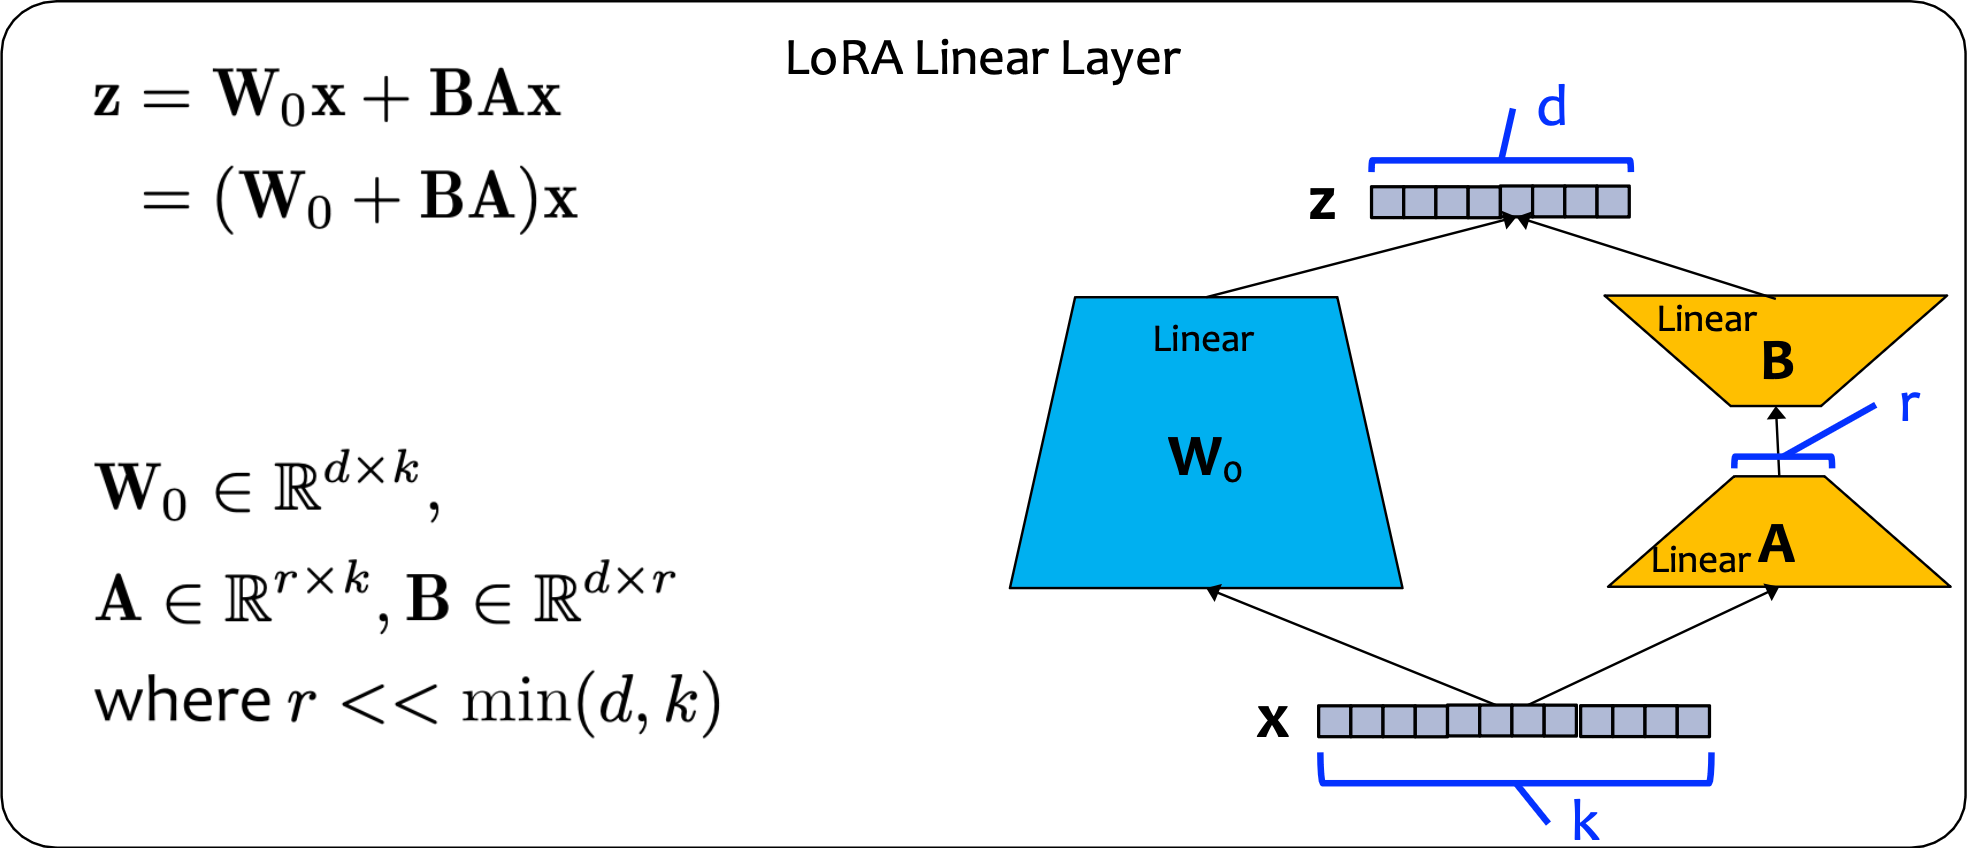

We can see the whole process in the image above. Also about its usages, we can later put it beside any learnable $W$ like the image below.

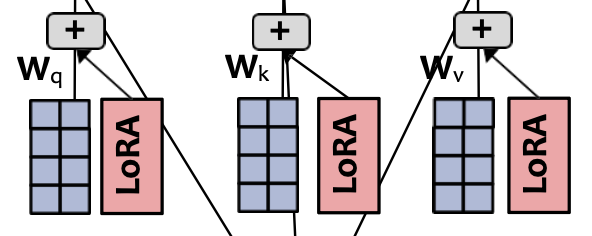

Overall we can say that via `LoRA` we try to learn a much lower-dimensional parameter and thus we decrease the computation and memory cost.

In [21]:
lora_model = AutoModelForCausalLM.from_pretrained(gpt_2_medium_model_name)

In [22]:
# Print the model artitechture
print(lora_model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)


In [23]:

# TODO: Define your LoRA configuration using LoraConfig class from peft library
#       Apply the LoRA on Conv1D modules (c_attn and c_proj) of GPT2Attention blocks (attn).
#       Set fan_in_fan_out to True
#       Set task_type to CAUSAL_LM

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    fan_in_fan_out=True
)

# # TODO: Wrraped the transformer module of GPT2LMHeadModel with above lora config
# #       using get_peft_model function
lora_model = get_peft_model(lora_model, lora_config)

# TODO: Print number of trainable parameters
lora_model.print_trainable_parameters()

trainable params: 2,162,688 || all params: 356,985,856 || trainable%: 0.6058


In [24]:
# Print the model artitechture and see the changes
print(lora_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 1024)
        (wpe): Embedding(1024, 1024)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-23): 24 x GPT2Block(
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=3072, nx=1024)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
      

In [25]:
# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [26]:
# TODO: Get reserved memory from cuda
gpu_memory_before = torch.cuda.memory_reserved()
# TODO: Train the model using trainer
train_output = trainer.train()
# TODO: Get reserved memory from cuda
gpu_memory_after = torch.cuda.memory_reserved()

# Report the training time and gpu memory consumption
print(f"Training time: {train_output.metrics['train_runtime']:.4f} seconds")
print(f"GPU memory used: {gpu_memory_after - gpu_memory_before:.4f} bytes")

Step,Training Loss


Training time: 50.4468 seconds
GPU memory used: 2021654528.0000 bytes


In [27]:
# TODO: Evaluate model on eval_dataset
eval_output = trainer.evaluate(eval_dataset=eval_dataset)

print(f"eval_loss = {eval_output['eval_loss']:.4f}")

eval_loss = 2.8789


In [28]:
# Delete the model
del lora_model
del trainer

In [29]:
# Empty the GPU memory (Run this cell twice if the GPU RAM is not close or less than 1.5Gb)
gc.collect()
torch.cuda.empty_cache()

In [30]:
ranks = [4, 16, 64, 256]

for r in ranks:
    print(f"\n=== LoRA rank: {r} ===")
    
    lora_model = AutoModelForCausalLM.from_pretrained(gpt_2_medium_model_name)

    lora_config = LoraConfig(
        r=r,
        lora_alpha=8 * r,
        target_modules=["c_attn", "c_proj"],
        lora_dropout=0.1,
        bias="none",
        task_type="CAUSAL_LM",
        fan_in_fan_out=True
    )

    lora_model = get_peft_model(lora_model, lora_config)
    
    lora_model.print_trainable_parameters()

    trainer = Trainer(
        model=lora_model,
        args=training_args,
        train_dataset=train_dataset,
    )

    
    gpu_memory_before = torch.cuda.memory_reserved()
    train_output = trainer.train()
    gpu_memory_after = torch.cuda.memory_reserved()

    print(f"Training time: {train_output.metrics['train_runtime']:.4f} seconds")
    print(f"GPU memory used: {gpu_memory_after - gpu_memory_before:.4f} bytes")

    eval_output = trainer.evaluate(eval_dataset=eval_dataset)
    print(f"eval_loss = {eval_output['eval_loss']:.4f}")

    for _ in range(3):
        torch.cuda.empty_cache()
        gc.collect()


=== LoRA rank: 4 ===
trainable params: 1,081,344 || all params: 355,904,512 || trainable%: 0.3038


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss


Training time: 51.4683 seconds
GPU memory used: 2013265920.0000 bytes


eval_loss = 2.8171

=== LoRA rank: 16 ===
trainable params: 4,325,376 || all params: 359,148,544 || trainable%: 1.2043


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss


Training time: 50.7115 seconds
GPU memory used: 580911104.0000 bytes


eval_loss = 1.3031

=== LoRA rank: 64 ===
trainable params: 17,301,504 || all params: 372,124,672 || trainable%: 4.6494


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss


Training time: 51.8983 seconds
GPU memory used: 731906048.0000 bytes


eval_loss = 1.2146

=== LoRA rank: 256 ===
trainable params: 69,206,016 || all params: 424,029,184 || trainable%: 16.3211


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss


Training time: 58.7668 seconds
GPU memory used: 1042284544.0000 bytes


eval_loss = 1.1126


In [31]:
del lora_model
del trainer

In [32]:
gc.collect()
torch.cuda.empty_cache()

#### Run LoRA for different rank values

Fine-tune the GPT-2 model with different rank values. (Be sure to change the alpha value according to the rank so that the results are fair.)

Enter the requested items in the table.

Compare the values ​​obtained and explain their differences.

TODO

| Method | Training Time(s) | Training Memory(Gb) | Validation Loss| #Trainable Params(M)|
|:-:|:-:|:-:|:-:|:-:|
| Zero-Shot         | N/A  | N/A  | 6.9568 | N/A |
| Full Fine-Tuning  | 71.5980  | 5.5427  | 1.0844 | 354.8232 |
| Prefix Tuning     | 46.8647  | 2.1684  | 1.4616 | 38.6055 |
| Lora rank=4       | 51.4683  | 2.0132  | 2.8171 | 1.0813 |
| Lora rank=16      | 50.7115  | 0.5809  | 1.3031 | 4.3253 |
| Lora rank=64      | 51.8983  | 0.7319  | 1.2146 | 17.3015 |
| Lora rank=256     | 58.7668  | 1.0422  | 1.1126 | 69.2060 |




<font color=cyan>

First we analyze each of the PEFT method individually. For each of them we can say that:

- `Zero-Shot` performance isn't that good, since the model is evaluated without any task-specific adaptation and basically no fine-tuning.

- `Full Fine-Tuning` has the best performance (it also has the lowest validation loss in the table above) but also has a much higher cost (as expected). It has a very high GPU memory usage and training time, and also updates all model parameters (~355M).

- `Prefix Tuning` offers a quite good balance, tuning only a small subset (~39M) of parameters. It reduces training memory and time significantly compared to full FT, but at the cost of slightly higher loss.

- `LoRA (Low-Rank Adaptation)` also offers a quite good balance. Besides that by using different ranks we can see that:

  - It gradually improves its performance, with rank 256 nearly matching full fine-tuning's performance.

  - We can control the amount of parameters it uses and also its memory usage to match our needs.

  - At rank 16 or 64, it hits its quite peek. Low memory usage and also a quite low validation loss.

To conclude we can say that PEFT methods like Prefix Tuning and LoRA allow for scalable training of large models under resource constraints. When GPU memory is limited, LoRA with a moderate rank (16–64) offers a strong balance between performance and efficiency, making it a practical choice for most real-world scenarios. (Another thing is that in this example the difference between Full FT and other methods like LoRA wasn't that much (about 15seconds time-wise), thus it wasn't really a good example to compare their performances, but in other real-world examples, methods like Full FT have a much higher computational and memory cost and thus methods like Prefix Tuning or LoRA are would be more powerful).


## Implement LoRA from scratch (30 pt)

In [33]:
custom_lora_model = AutoModelForCausalLM.from_pretrained(gpt_2_medium_model_name)
print(custom_lora_model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)


In [34]:
import math

class LoRALayer(nn.Module):
    def __init__(self, base_layer, rank=8, alpha=16):
        super().__init__()
        self.rank = rank
        self.alpha = alpha
        self.scale = self.alpha / self.rank
        
        self.base_layer = base_layer

        self.in_features = base_layer.weight.shape[0]
        self.out_features = base_layer.weight.shape[1]

        self.lora_A = nn.Linear(self.in_features, rank, bias=False)
        self.lora_B = nn.Linear(rank, self.out_features, bias=False)

        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)

    def forward(self, x):
        original_output = self.base_layer(x)
        lora_output = self.lora_B(self.lora_A(x))
        return original_output + lora_output * self.scale

In [35]:
# TODO: Freeze the model

for param in custom_lora_model.parameters():
    param.requires_grad = False

# TODO: Loop over list of GPT2Blocks of model and replace the Conv1D
#       modules (c_attn, c_proj) of them with your LoRALayer

for block in custom_lora_model.transformer.h:
    block.attn.c_attn = LoRALayer(block.attn.c_attn)
    block.attn.c_proj = LoRALayer(block.attn.c_proj)

In [36]:
print(custom_lora_model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): LoRALayer(
            (base_layer): Conv1D(nf=3072, nx=1024)
            (lora_A): Linear(in_features=1024, out_features=8, bias=False)
            (lora_B): Linear(in_features=8, out_features=3072, bias=False)
          )
          (c_proj): LoRALayer(
            (base_layer): Conv1D(nf=1024, nx=1024)
            (lora_A): Linear(in_features=1024, out_features=8, bias=False)
            (lora_B): Linear(in_features=8, out_features=1024, bias=False)
          )
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ml

In [37]:
# Initialize Trainer
trainer = Trainer(
    model=custom_lora_model,
    args=training_args,
    train_dataset=train_dataset,
)

In [38]:
# TODO: Get reserved memory from cuda
gpu_memory_before = torch.cuda.memory_reserved()
# TODO: Train the model using trainer
train_output = trainer.train()
# TODO: Get reserved memory from cuda
gpu_memory_after = torch.cuda.memory_reserved()

# Report the training time and gpu memory consumption
print(f"Training time: {train_output.metrics['train_runtime']:.4f} seconds")
print(f"GPU memory used: {gpu_memory_after - gpu_memory_before:.4f} bytes")

Step,Training Loss


Training time: 46.4387 seconds
GPU memory used: 1694498816.0000 bytes


In [39]:
# TODO: Evaluate model on eval_dataset
eval_output = trainer.evaluate(eval_dataset=eval_dataset)

print(f"eval_loss = {eval_output['eval_loss']:.4f}")

eval_loss = 4.6463


In [40]:
# Delete the model
del custom_lora_model
del trainer

In [41]:
# Empty the GPU memory (Run this cell twice if the GPU RAM is not close or less than 1.5Gb)
gc.collect()
torch.cuda.empty_cache()